**Reference**: <https://daviddalpiaz.github.io/appliedstats/analysis-of-variance.html>

In [1]:
library(tidyverse)
library(faraway)

-- Attaching packages ----------------------------------------------------------------------------------------------------------------------------------------------------- tidyverse 1.3.0 --

v ggplot2 3.3.2     v purrr   0.3.4
v tibble  3.0.4     v dplyr   1.0.2
v tidyr   1.1.2     v stringr 1.4.0
v readr   1.4.0     v forcats 0.5.0

-- Conflicts -------------------------------------------------------------------------------------------------------------------------------------------------------- tidyverse_conflicts() --
x dplyr::filter() masks stats::filter()
x dplyr::lag()    masks stats::lag()



In [2]:
coagulation

,coag,diet
,<dbl>,<fct>
1,62,A
2,60,A
3,63,A
4,59,A
5,63,B
6,67,B
7,71,B
8,64,B
9,65,B


In [4]:
res <- aov(coag ~ diet, data = coagulation)
res

Call:
   aov(formula = coag ~ diet, data = coagulation)

Terms:
                diet Residuals
Sum of Squares   228       112
Deg. of Freedom    3        20

Residual standard error: 2.366432
Estimated effects may be unbalanced

In [5]:
names(res)

[1] "coefficients"  "residuals"     "effects"       "rank"         
 [5] "fitted.values" "assign"        "qr"            "df.residual"  
 [9] "contrasts"     "xlevels"       "call"          "terms"        
[13] "model"

In [6]:
summary(res)

            Df Sum Sq Mean Sq F value   Pr(>F)    
diet         3    228    76.0   13.57 4.66e-05 ***
Residuals   20    112     5.6                     
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

# Simulation

In [13]:
sim_anova <- function(ngroups = 4,
                      group_size = 20,
                      group_mean = rep(0, 4),
                      sigma = 1,
                      stat = F) {
  simulated_data <- group_mean %>%
    set_names(LETTERS[1:ngroups]) %>%
    map_dfc(~ rnorm(group_size, ., sigma)) %>%
    pivot_longer(everything(), names_to = "group", values_to = "value")
  mod <- lm(value ~ group, data = simulated_data)
  report <- mod %>% broom::glance()
  ifelse(stat, report$p.value, report$statistic)
}


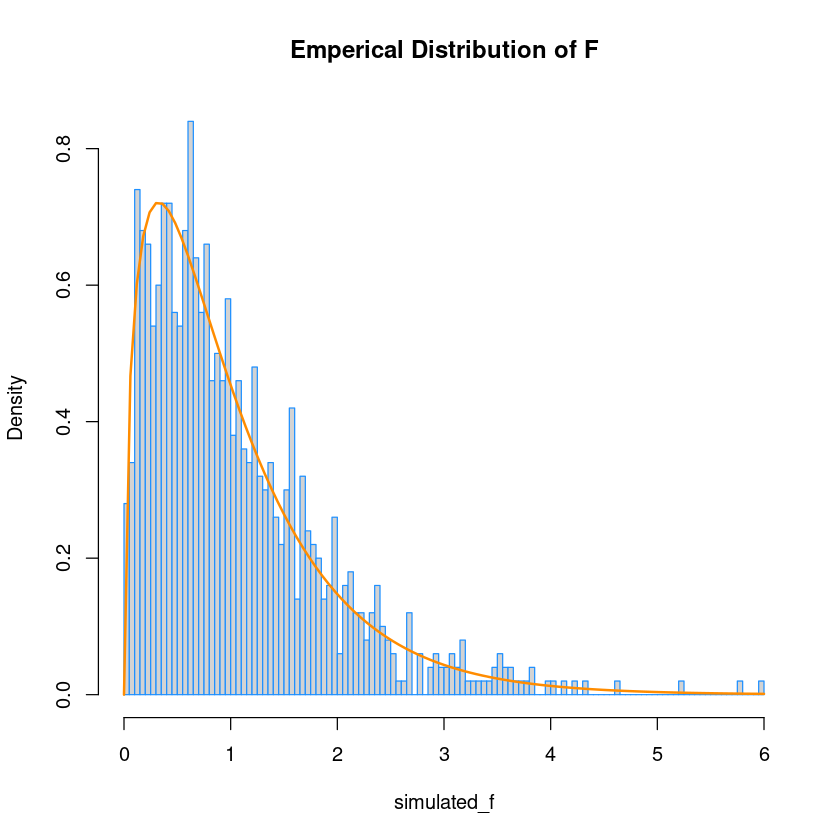

In [14]:
nsims <- 1000
simulated_f <- replicate(nsims, sim_anova())

hist(simulated_f, breaks = 100, prob = T, border = "dodgerblue", main = "Emperical Distribution of F")
curve(df(x, df1 = ngroups - 1, df2 = ngroups * group_size - ngroups), add = T, lwd = 2, col = "darkorange")

# Power

We need high power when we want to have high probability of discovering true effect (reject null hypothesis when it is false). Now that we’re performing experiments, getting more data means finding more test subjects, running more lab tests, etc. In other words, it will cost more time and money.

We’d like to design our experiment so that we have a good chance of detecting an interesting effect size, without spending too much money. There’s no point in running an experiment if there’s only a very low chance that it has a significant result that you care about. (Remember, not all statistically significant results have practical value.)

That is, for a true difference of means that we deem interesting, we want the test to reject with high probability.

A number of things can affect the power of a test:

- **Effect size**. It is easier to detect larger effects.
- **Noise level   σ**. The less noise, the easier it is to detect signal (effect). We don’t have much ability to control this, except maybe to measure more accurately.
- **Significance level   α**. Lower significance level makes rejecting more difficult. (But also allows for less false positives.)
- **Sample size**. Large samples means easier to detect effects.
- **Balanced design**. An equal number of observations per group leads to higher power.

---
**Effect size**: The larger the effect size, the easier to detect true effect

In [19]:
# mu_a = 5, mu_b = 6
p.value <- rerun(nsims, sim_anova(ngroups = 2, sigma = 3, group_mean = c(5, 6), stat = T))
# at 0.05 significant level, the probability of reject H_0 when it is false
mean(p.value < 0.05)

[1] 0.176

In [21]:
# increase size effect, mu_a = 5, mu_b = 8
p.value <- rerun(nsims, sim_anova(ngroups = 2, sigma = 3, group_mean = c(5, 8), stat = T))
mean(p.value < 0.05)

[1] 0.866

---
**Noise level**: The less noise, the easier it is to detect signal (effect)

In [22]:
# sigma = 5
p.value <- rerun(nsims, sim_anova(ngroups = 2, sigma = 5, group_mean = c(5, 7), stat = T))
mean(p.value < 0.05)

[1] 0.233

In [23]:
# sigma = 2
p.value <- rerun(nsims, sim_anova(ngroups = 2, sigma = 2, group_mean = c(5, 7), stat = T))
mean(p.value < 0.05)

[1] 0.864

---
**Significant level**: The larger alpha is ,the larger the power of the test

In [24]:
# alpha = 0.05
p.value <- rerun(nsims, sim_anova(ngroups = 2, sigma = 3, group_mean = c(5, 7), stat = T))
mean(p.value < 0.05)

[1] 0.537

In [25]:
# alpha = 0.01
p.value <- rerun(nsims, sim_anova(ngroups = 2, sigma = 3, group_mean = c(5, 7), stat = T))
mean(p.value < 0.01)

[1] 0.308

---
**sample size**: The larger the sample size, the larger the power is 

In [26]:
# sample size of 20
p.value <- rerun(nsims, sim_anova(group_size = 20, ngroups = 2, sigma = 3, group_mean = c(5, 7), stat = T))
mean(p.value < 0.05)

[1] 0.513

In [27]:
# sample size of 50
p.value <- rerun(nsims, sim_anova(group_size = 50, ngroups = 2, sigma = 3, group_mean = c(5, 7), stat = T))
mean(p.value < 0.05)

[1] 0.9

# Post hoc testing

Suppose we reject the null hypothesis from the ANOVA test for equal means. That tells us that the means are different. But which means? All of them? Some of them? The obvious strategy is to test all possible comparisons of two means. We can do this easily in R.

In [28]:
with(coagulation, pairwise.t.test(coag, diet, p.adj = "none"))


	Pairwise comparisons using t tests with pooled SD 

data:  coag and diet 

  A       B       C      
B 0.00380 -       -      
C 0.00018 0.15878 -      
D 1.00000 0.00086 2.3e-05

P value adjustment method: none 

**Multiple testing**: Bad!!! If we do not adjust p value, for each test, with 95% confidence, let's say we perform 50 test, then the confidence will be reduce to $.95^{50}$, approximately 0.077 confidence. That means we will more likely to make type I error (false positive), to reduce this, we need to adjust p-value by increasing its value so that we less likely to reject $H_0$, so less likely to make type I error when perform multiple testing 

The adjustment is an attempt to correct for the multiple testing problem. (See also: Relevant XKCD. ) Imagine that you knew ahead of time that you were going to perform 100   t -tests. Suppose you wish to do this with a false positive rate of   α = 0.05
 . If we use this significance level for each test, for 100 tests, we then expect 5 false positives. That means, with 100 tests, we’re almost guaranteed to have at least one error.

What we’d really like, is for the family-wise error rate to be 0.05. If we consider the 100 tests to be a single “experiment” the FWER is the rate of one or more false positives for in the full experiment (100 tests). Consider it an error rate for an entire procedure, instead of a single test.
With this in mind, one of the simplest adjustments we can make, is to increase the p-values for each test, depending on the number of tests. In particular the Bonferroni correction simply multiplies by the number of tests.

In [29]:
with(coagulation, pairwise.t.test(coag, diet, p.adj = "bonferroni"))


	Pairwise comparisons using t tests with pooled SD 

data:  coag and diet 

  A       B       C      
B 0.02282 -       -      
C 0.00108 0.95266 -      
D 1.00000 0.00518 0.00014

P value adjustment method: bonferroni 

We see that these p-values are much higher than the unadjusted p-values, thus, we are less likely to reject each tests. As a result, the FWER is 0.05, instead of an error rate of 0.05 for each test.

We can simulate the 100 test scenario to illustrate this point.

In [37]:
get_p_val = function() {
  
  # create data for two groups, equal mean
  y = rnorm(20, mean = 0, sd = 1)
  g = c(rep("A", 10), rep("B", 10))
  
  # p-value of t-test when null is true
  broom::glance(t.test(y ~ g, var.equal = TRUE))$p.value
  
}

set.seed(1337)

# FWER with 100 tests
# desired rate = 0.05
# no adjustment
mean(replicate(1000, any(replicate(100, get_p_val()) < 0.05)))

[1] 0.994

In [38]:
# FWER with 100 tests
# desired rate = 0.05
# bonferroni adjustment
mean(replicate(1000, any(p.adjust(replicate(100, get_p_val()), "bonferroni") < 0.05)))

[1] 0.058

Tukey’s Honest Significance difference can be applied directly to an object which was created using aov(). It will adjust the p-values of the pairwise comparisons of the means to control the FWER, in this case, for 0.05. Notice it also gives confidence intervals for the difference of the means.

In [30]:
coag_aov <- aov(coag ~ diet, data = coagulation)
TukeyHSD(coag_aov, conf.level = .95)

  Tukey multiple comparisons of means
    95% family-wise confidence level

Fit: aov(formula = coag ~ diet, data = coagulation)

$diet
    diff         lwr       upr     p adj
B-A    5   0.7245544  9.275446 0.0183283
C-A    7   2.7245544 11.275446 0.0009577
D-A    0  -4.0560438  4.056044 1.0000000
C-B    2  -1.8240748  5.824075 0.4766005
D-B   -5  -8.5770944 -1.422906 0.0044114
D-C   -7 -10.5770944 -3.422906 0.0001268


Based on these results, we see no difference between A and D as well as B and C. All other pairwise comparisons are significant. If you return to the original boxplot, these results should not be surprising.

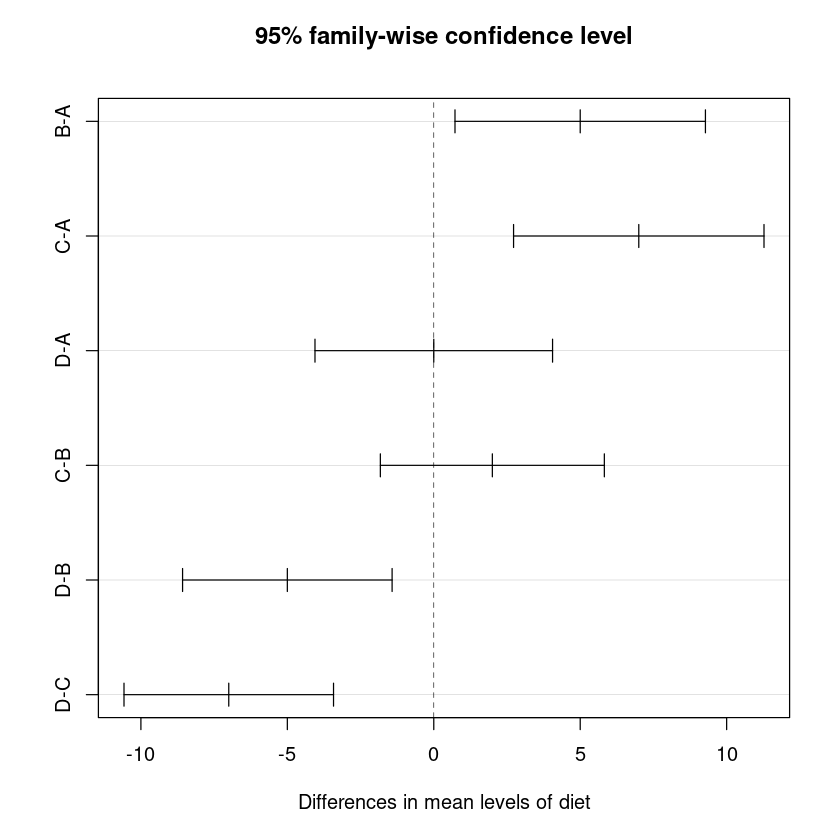

In [39]:
plot(TukeyHSD(coag_aov, conf.level = .95))

# 2-way ANOVA

 48 rats were randomly assigned both one of three poisons and one of four possible treatments. The experimenters then measures their survival time in tens of hours. A total of 12 groups, each with 4 replicates.



In [40]:
rats

,time,poison,treat
,<dbl>,<fct>,<fct>
1,0.31,I,A
2,0.82,I,B
3,0.43,I,C
4,0.45,I,D
5,0.45,I,A
6,1.10,I,B
7,0.45,I,C
8,0.71,I,D
9,0.46,I,A


`summarise()` regrouping output by 'poison' (override with `.groups` argument)



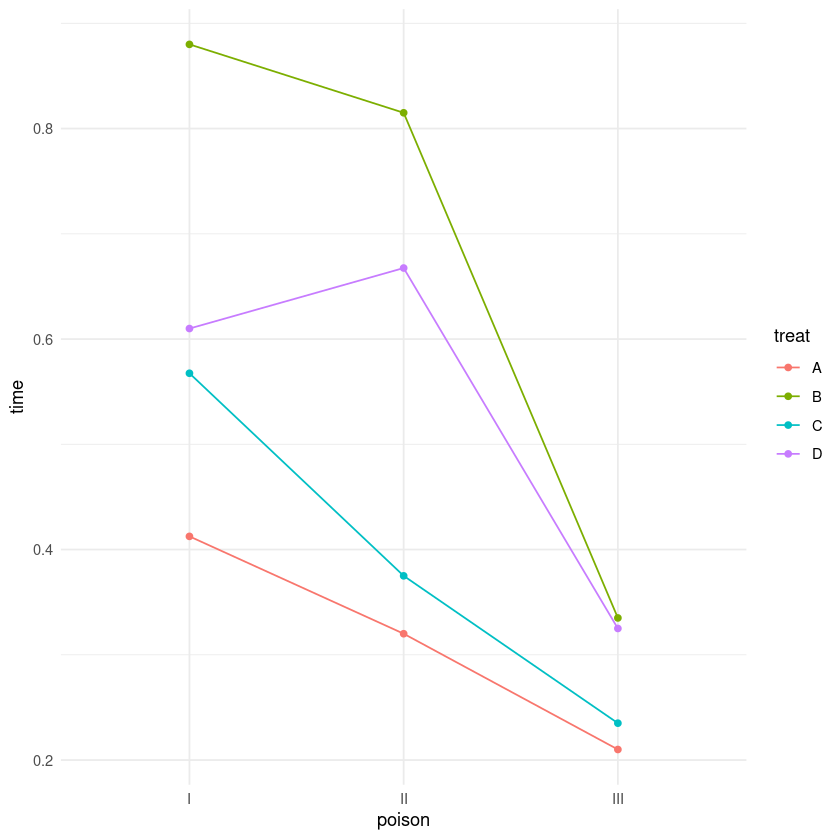

In [43]:
rats %>% 
group_by(poison, treat) %>% 
summarize(time = mean(time)) %>% 
ggplot(aes(poison, time, group = treat, color = treat)) +
geom_point() + 
geom_line() +
theme_minimal()

If there is not interaction, thus an additive model, we would expect to see parallel lines. That would mean, when we change the level of one factor, there can be an effect on the response. However, the difference between the levels of the other factor should still be the same.

The obvious indication of interaction would be lines that cross while heading in different directions. Here we don’t see that, but the lines aren’t strictly parallel, and there is some overlap on the right panel. However, is this interaction effect significant?

Let’s fit each of the possible models, then investigate their estimates for each of the group means.

In [44]:
rats_null <- lm(time ~ 1, data = rats)
rats_poison <- lm(time ~ poison, data = rats)
rats_treat <- lm(time ~ poison, data = rats)
rats_additive <- lm(time ~ poison + treat, data = rats)
rats_interaction <- lm(time ~ poison * treat, data = rats)

In [47]:
rats_aov <- aov(time ~ poison * treat, data = rats)
rats_aov

Call:
   aov(formula = time ~ poison * treat, data = rats)

Terms:
                   poison     treat poison:treat Residuals
Sum of Squares  1.0330125 0.9212062    0.2501375 0.8007250
Deg. of Freedom         2         3            6        36

Residual standard error: 0.1491387
Estimated effects may be unbalanced

In [48]:
summary(rats_aov)

             Df Sum Sq Mean Sq F value   Pr(>F)    
poison        2 1.0330  0.5165  23.222 3.33e-07 ***
treat         3 0.9212  0.3071  13.806 3.78e-06 ***
poison:treat  6 0.2501  0.0417   1.874    0.112    
Residuals    36 0.8007  0.0222                     
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

These tests should be performed according to the model **hierarchy**. First consider the test of interaction. If it is significant, we select the interaction model and perform no further testing. If interaction is not significant, we then consider the necessity of the individual factors of the additive model.



![](https://daviddalpiaz.github.io/appliedstats/images/hierarchy.png)

In the example above, the p-value of interaction is high (0.11 > 0.05), we we fail to reject the null hypothesis which states the interaction is not significant. Now we know the interaction is not significant, we will move on to test the additive model. With the additive model, we see that both factors (treat and poison) are significant, so we select the additive model

In [52]:
TukeyHSD(aov(time ~ poison + treat, data = rats))

  Tukey multiple comparisons of means
    95% family-wise confidence level

Fit: aov(formula = time ~ poison + treat, data = rats)

$poison
            diff        lwr        upr     p adj
II-I   -0.073125 -0.2089936  0.0627436 0.3989657
III-I  -0.341250 -0.4771186 -0.2053814 0.0000008
III-II -0.268125 -0.4039936 -0.1322564 0.0000606

$treat
           diff         lwr         upr     p adj
B-A  0.36250000  0.18976135  0.53523865 0.0000083
C-A  0.07833333 -0.09440532  0.25107198 0.6221729
D-A  0.22000000  0.04726135  0.39273865 0.0076661
C-B -0.28416667 -0.45690532 -0.11142802 0.0004090
D-B -0.14250000 -0.31523865  0.03023865 0.1380432
D-C  0.14166667 -0.03107198  0.31440532 0.1416151


For an example with interaction, we investigate the `warpbreaks` dataset, a default dataset in R.

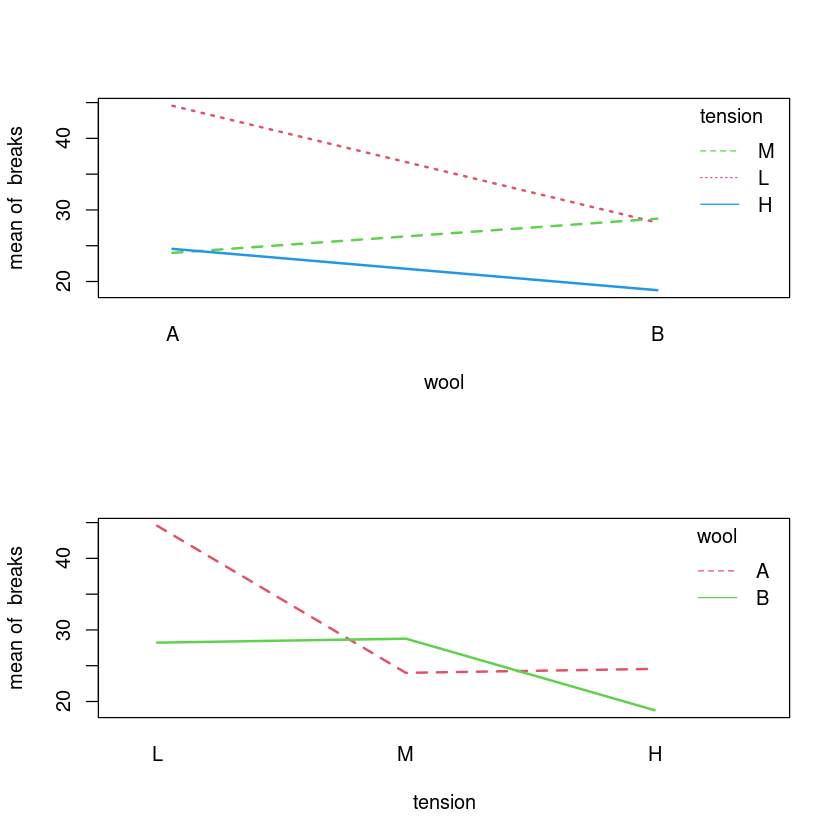

In [54]:
par(mfrow = c(2, 1))
with(warpbreaks, interaction.plot(wool, tension, breaks, lwd = 2, col = 2:4))
with(warpbreaks, interaction.plot(tension, wool, breaks, lwd = 2, col = 2:3))

In [55]:
summary(aov(breaks ~ wool * tension, data = warpbreaks))

             Df Sum Sq Mean Sq F value   Pr(>F)    
wool          1    451   450.7   3.765 0.058213 .  
tension       2   2034  1017.1   8.498 0.000693 ***
wool:tension  2   1003   501.4   4.189 0.021044 *  
Residuals    48   5745   119.7                     
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Using an   α of   0.05 the ANOVA test finds that the interaction is significant, so we use the interaction model here.

# The relationship between ANOVA and Linear regression

In [2]:
library(tidyverse)
# one-way anova
scores <- tribble(
  ~year1, ~year2, ~year3,
  82, 71, 64,
  93, 62, 73,
  61, 85, 87,
  74, 94, 91,
  69, 78, 56,
  70, 66, 78,
  53, 71, 87,
  64, 71, 82
)


scores_long <- scores %>% 
  mutate(id = row_number()) %>% 
  pivot_longer(!id, names_to = "year", values_to = "score")  %>% 
  mutate(year = as.factor(year), id = as.factor(id))

scores_long

id,year,score
<fct>,<fct>,<dbl>
1,year1,82
1,year2,71
1,year3,64
2,year1,93
2,year2,62
2,year3,73
3,year1,61
3,year2,85
3,year3,87


In [3]:
# one-way ANOVA
aov_scores <- aov(score ~ year, data = scores_long)
summary(aov_scores)

mod_scores <- lm(score ~ year, data = scores_long)
summary(mod_scores)

summary(aov_scores)
anova(mod_scores)

scores_long %>% 
  mutate(score = fitted(mod_scores)) %>% 
  pivot_wider(names_from = year, values_from = score)

            Df Sum Sq Mean Sq F value Pr(>F)
year         2    172    86.0   0.621  0.547
Residuals   21   2906   138.4               


Call:
lm(formula = score ~ year, data = scores_long)

Residuals:
   Min     1Q Median     3Q    Max 
-21.25  -7.25  -1.25   9.75  22.25 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept)   70.750      4.159  17.010  9.3e-14 ***
yearyear2      4.000      5.882   0.680    0.504    
yearyear3      6.500      5.882   1.105    0.282    
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 11.76 on 21 degrees of freedom
Multiple R-squared:  0.05587,	Adjusted R-squared:  -0.03405 
F-statistic: 0.6214 on 2 and 21 DF,  p-value: 0.5468


            Df Sum Sq Mean Sq F value Pr(>F)
year         2    172    86.0   0.621  0.547
Residuals   21   2906   138.4               

,Df,Sum Sq,Mean Sq,F value,Pr(>F)
,<int>,<dbl>,<dbl>,<dbl>,<dbl>
year,2,172.0,86.0000,0.6213659,0.5467985
Residuals,21,2906.5,138.4048,NA,NA


id,year1,year2,year3
<fct>,<dbl>,<dbl>,<dbl>
1,70.75,74.75,77.25
2,70.75,74.75,77.25
3,70.75,74.75,77.25
4,70.75,74.75,77.25
5,70.75,74.75,77.25
6,70.75,74.75,77.25
7,70.75,74.75,77.25
8,70.75,74.75,77.25


In [5]:
# two-way anova (without interaction)
scores_long <- scores %>% 
  mutate(id = row_number()) %>% 
  pivot_longer(!id, names_to = "year", values_to = "score")  %>% 
  mutate(year = as.factor(year), id = as.factor(id))

aov_twoway_scores <- aov(score ~ year + id, data = scores_long)
summary(aov_twoway_scores)

# linear regression that is equivalent to ANOVA
mod_twoway_scores <- lm(score ~ year + id, data = scores_long)
summary(mod_twoway_scores)

summary(aov_twoway_scores)
anova(mod_twoway_scores)

scores_long %>% 
  mutate(score = fitted(mod_twoway_scores)) %>% 
  pivot_wider(names_from = year, values_from = score)

            Df Sum Sq Mean Sq F value Pr(>F)
year         2  172.0    86.0   0.547  0.591
id           7  705.8   100.8   0.641  0.716
Residuals   14 2200.7   157.2               


Call:
lm(formula = score ~ year + id, data = scores_long)

Residuals:
     Min       1Q   Median       3Q      Max 
-14.6667  -6.7083   0.9167   6.7083  20.5000 

Coefficients:
              Estimate Std. Error t value Pr(>|t|)    
(Intercept)  6.883e+01  8.093e+00   8.505 6.67e-07 ***
yearyear2    4.000e+00  6.269e+00   0.638    0.534    
yearyear3    6.500e+00  6.269e+00   1.037    0.317    
id2          3.667e+00  1.024e+01   0.358    0.726    
id3          5.333e+00  1.024e+01   0.521    0.611    
id4          1.400e+01  1.024e+01   1.368    0.193    
id5         -4.667e+00  1.024e+01  -0.456    0.655    
id6         -1.000e+00  1.024e+01  -0.098    0.924    
id7         -2.000e+00  1.024e+01  -0.195    0.848    
id8         -7.252e-15  1.024e+01   0.000    1.000    
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 12.54 on 14 degrees of freedom
Multiple R-squared:  0.2851,	Adjusted R-squared:  -0.1744 
F-statistic: 0.6205 on 9 and 14 DF

            Df Sum Sq Mean Sq F value Pr(>F)
year         2  172.0    86.0   0.547  0.591
id           7  705.8   100.8   0.641  0.716
Residuals   14 2200.7   157.2               

,Df,Sum Sq,Mean Sq,F value,Pr(>F)
,<int>,<dbl>,<dbl>,<dbl>,<dbl>
year,2,172.0000,86.0000,0.5471069,0.5905039
id,7,705.8333,100.8333,0.6414723,0.7156325
Residuals,14,2200.6667,157.1905,NA,NA


id,year1,year2,year3
<fct>,<dbl>,<dbl>,<dbl>
1,68.83333,72.83333,75.33333
2,72.50000,76.50000,79.00000
3,74.16667,78.16667,80.66667
4,82.83333,86.83333,89.33333
5,64.16667,68.16667,70.66667
6,67.83333,71.83333,74.33333
7,66.83333,70.83333,73.33333
8,68.83333,72.83333,75.33333
